# Au blé d'or

Réalisé par *LOUISOT Pierre, POLLET Florent* (2021)

In [88]:
# Imports

import numpy as np
from scipy import optimize
import casadi
from casadi import SX, mtimes, transpose, exp, sum1, fmin, MX
import matplotlib.pyplot as plt
import warnings

np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')


## 1. Etude du problème d'optimisation

### Question 1

Le coût (2) correspond au profit de la boulangerie : $\sum(produits)$ $-$ $\sum(coûts)$

- $c^T r$ est le coût d'achat des matières premières
- $v^T q$ est le montant rapporté par la vente d'une quantité de produits $q$ (tout ce qui a été produit)
- $v^T d$ est le montant rapporté par la vente d'une quantité de produits $d$ (tout ce qui a été demandé)

Ainsi, le terme $\min\{q,d\}$ correspond à la quantité minimum entre ce qui a été produit ou demandé. En effet, le facteur limitant des gains dépend si la demande est supérieure à la production ou si la production est supérieure à la demande (dans le cas d'économies d'échelle par exemple, cela peut être rentable).


### Question 2

Ce terme avec un $\min$ n'est pas un opérateur différentiable et ne permet pas d'appliquer les méthodes du cours les plus efficaces.

### Question 3

Cette formule fait penser à la statistique de Maxwell-Boltzmann : un barycentre avec des pondérations exponentielles.

Soit $i \in [|1, p|]$.

Posons $\lambda_i = \dfrac{\exp(-\alpha q_i)}{\exp(-\alpha q_i)+\exp(-\alpha d_i)} \in [0, 1]$. Alors $h_i = \lambda_i q_i+(1-\lambda_i) d_i$ (barycentre).

De plus, on note $r_i = \frac{\lambda_i}{1-\lambda_i}=\exp(-\alpha(q_i-d_i))$.

On considère (et ce sera vérifié dans la suite) que $|\alpha(q_i-d_i)|>>1$. Cela est justifié dès que $\alpha >> 1$.

Cas 1 : $q_i > d_i$. Montrons que $h_i \approx d_i$.

$q_i > d_i$ donc $\alpha(q_i-d_i) >> 1$ puis $r_i << 1$, d'où $h_i \approx d_i$.

Cas 2 : $q_i < d_i$. On procède de manière similaire par symétrie.

On a donc maintenant une fonction concave différentiable ce qui permet de se placer dans un cadre où l'on dispose plus de résultats. En effet, $c^T r$ est linéaire et pour tout $i$, $h_i$ est concave.

### Question 4

On suppose que $d$ est fixé. On pose :

- $z = (q, r)$ (de taille $n=p + m$)
- $f(z) = f(q, r) = c^T r - v^T h(q, d)$, à valeurs dans $\mathbb{R}$
- $c(z) = c(q, r) = A q - r$ ($m$ contraintes)

## 2. Etude et résolution numérique

### Question 5

Puisque la fonction $f$ est deux-fois différentiable, on peut utiliser la méthode la plus efficace pour l'optimisation différentiable, c'est-à-dire la méthode de Newton. Toutefois, il faut prendre en compte les contraintes inégalités. On peut donc penser à une optimisation avec pénalités pour utiliser Newton.

Une autre approche serait les algorithmes d'optimisation différentiable sous contraintes, comme celui Uzawa ou d'Arrow-Hurwicz (les contraintes sont linéaires). Ces algorithmes sont toutefois a priori moins efficaces que la méthode de Newton car cela n'utilise que l'ordre un et non l'ordre deux.

### Question 6

On note que $1$ n'est pas vraiment négligeable devant $\alpha$.

In [89]:
# Définition des variables du problème

def q6(a=0.1):
    alpha = a
    c = 1e-3*np.array([30.,1.,1.3,4., 1.])
    v = np.array([0.9, 1.5, 1.1])
    d = np.array([400., 67., 33.])
    A = np.array([[3.5,2.,1.],[250.,80., 25.],[0., 8., 3.],[0., 40., 10.], [0., 8.5, 0.]])
    n = len(c)+len(d)
    return n, alpha, c, v, d, A

n, alpha, c, v, d, A = q6()
x0 = np.zeros(n)

In [90]:
# Résolution avec Casadi

k = len(d)
opti = casadi.Opti();

x = opti.variable(n)
q = x[0:k]
r = x[k:]
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)

def fun_hp(q, d, alpha=alpha):
    return (q*exp(-alpha*q)+d*exp(-alpha*d))/(exp(-alpha*q)+exp(-alpha*d))

f = mtimes(transpose(cp), r) - mtimes(transpose(vp), fun_hp(q, dp))
opti.minimize(f)
opti.subject_to(mtimes(ap, q) - r <= 0)

x0 = np.array([0.]*n)
opti.set_initial(x,x0)
options = {'print_time':False, 'ipopt':{'print_level':0}}
opti.solver('ipopt', options);

opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(dp, d)
opti.set_value(ap, A)

sol = opti.solve();
print(sol.value(x))

[   402.12704191     73.10746942     42.43483578   1596.09442137
 107441.22892767    712.1642646    3348.6471351     621.41349253]


In [91]:
# Résolution avec Scipy

def fun_h(q, d, alpha=alpha):
    return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))

def fun_f(z, d=d, A=A, c=c, v=v, alpha=alpha):
    q = z[:len(d)]
    r = z[len(d):]
    return c.T @ r - v.T @ fun_h(q, d, alpha)

def fun_c(z, A=A):
    q = z[:len(d)]
    r = z[len(d):]
    return A @ q - r

ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
res = optimize . minimize(fun_f, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -333.52157831268005
            Iterations: 63
            Function evaluations: 584
            Gradient evaluations: 63
[   402.12800137     73.10884775     42.43652509   1596.1022254
 107441.62129052    712.18035732   3348.71916112    621.42520591]


La valeur de la fonction de coût est négative, donc l'entreprise fait des profits.

On constate que les quantités optimales à produire sont légèrement supérieures à la demande. Cela est surprenant dans la mesure où notre modèle ne peut pas faire apparaitre d'économies d'échelle. Cette surproduction doit donc être due à un biais dans la résolution.

Nous allons donc regarder l'influence du paramètre exogène $\alpha$.



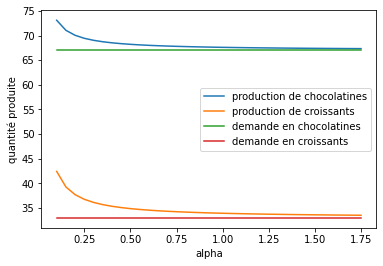

In [92]:
# Résolution avec différentes valeurs de alpha

baguettes_list, chocolats_list, croissants_list = [], [], []
alphas = np.arange(0.1, 1.8, 0.05)

for a in alphas:
    n, alpha, c, v, d, A = q6(a)
    
    def fun_h(q, d, alpha=alpha):
        return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))


    def fun_f(z, d=d, A=A, c=c, v=v, alpha=alpha):
        q = z[:len(d)]
        r = z[len(d):]
        return c.T @ r - v.T @ fun_h(q, d, alpha)

    def fun_c(z, A=A):
        q = z[:len(d)]
        r = z[len(d):]
        return A @ q - r

    ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
    res = optimize . minimize(fun_f, x0, method= 'SLSQP' ,
    constraints= [ineq_cons], options={ 'disp' : False, 'maxiter': 10000})
    
    baguettes, chocolats, croissants = res.x[:3]
    baguettes_list.append(baguettes)
    chocolats_list.append(chocolats)
    croissants_list.append(croissants)

plt.figure()
plt.plot(alphas, chocolats_list, label='production de chocolatines')
plt.plot(alphas, croissants_list, label='production de croissants')
plt.plot(alphas, 67*np.ones(len(alphas)), label='demande en chocolatines')
plt.plot(alphas, 33*np.ones(len(alphas)), label='demande en croissants')
plt.xlabel("alpha")
plt.ylabel("quantité produite")
plt.legend()
plt.show()


Cela pourrait donc être notre approximation du minimum qui serait en cause. Pour le vérifier, nous avons représenté les quantités produites selon la valeur du paramètre $\alpha$. Lorsqu'il augmente, c'est-à-dire lorsque notre approximation "se rapproche" de la fonction $\min$, on observe bien que les quantités produites tendent vers les quantités demandées par valeurs supérieures, ce qui confirme cette hypothèse. On peut donc conclure que la quantité optimale est la quantité demandée avec ces paramètres : cela est simplement dû au fait que le coût marginal est constant et inférieur au prix de vente. On a donc toujours intérêt à satisfaire toute la demande.

On peut également comparer aux résultats obtenus dans la dernière partie du problème : la demande est toujours exactement satisfaite.

### Question 7

a. Problème d'optimisation.

On calcule l'espérance de l'opposé du profit : $E(z)=\pi_1 f_1(z)+\pi_2 f_2(z)+\pi_3 f_3(z)$ où $f_i(z)= c^T r - v^T h(q, d^i)$

On minimise donc cette quantité $E(z)$ avec les mêmes contraintes.



In [93]:
# Variables du problème

def q7():
    d1 = np.array([400., 67., 33.])
    d2 = np.array([500., 80., 53.])
    d3 = np.array([300., 60., 43.])
    p1 = 0.5
    p2 = 0.3
    p3 = 0.2
    return d1, p1, d2, p2, d3, p3

ps = q7()
d1, p1, d2, p2, d3, p3 = ps

In [94]:
# Résolution avec Scipy

def fun_E(z, ps=ps):
    d1, p1, d2, p2, d3, p3 = ps
    return p1*fun_f(z, d1)+p2*fun_f(z, d2)+p3*fun_f(z, d3)

ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
res = optimize . minimize(fun_E, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -318.6411120994077
            Iterations: 70
            Function evaluations: 655
            Gradient evaluations: 70
[   400.38159564     79.75330097     53.2354237    1614.0776104
 107806.54858143    797.73267888   3722.48627591    677.90305827]


In [95]:
# Résolution avec Casadi

opti = casadi.Opti();

x = opti.variable(n)
q = x[0:k]
r = x[k:]
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(3, k)
pp = opti.parameter(k)
ap = opti.parameter(n-k,k)

f = 0
for j in range(3):
    f += pp[j]*(mtimes(transpose(cp), r) - mtimes(transpose(vp), fun_hp(q, transpose(dp[j,:]))))

opti.minimize(f)
opti.subject_to(mtimes(ap, q) - r <= 0)

x0 = np.array([0.]*n)
opti.set_initial(x,x0)
options = {'print_time':False, 'ipopt':{'print_level':0}}
opti.solver('ipopt', options);


opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(ap, A)
opti.set_value(pp, [p1, p2, p3])
opti.set_value(dp, np.array([d1, d2, d3]))

sol = opti.solve();
print(sol.value(x))
print(sol.value(f))

[   406.69842673     77.13921035     54.28956029   1632.01247461
 109202.9825197     779.98236557   3628.46401742    655.68329044]
-323.9598439928122


La demande espérée est $d = \begin{pmatrix}
  410 \\
  69.5 \\
  41
\end{pmatrix}$.

On distingue deux situations : pour les produits à forte valeur ajoutée (viennoiseries), on produit au-delà de la demande espérée car les bénéfices en cas de vente sont bien supérieures aux pertes en cas de surproduction ; au contraire, pour les produits à faible valeur ajoutée (baguettes), prendre un risque en produisant au-delà de l'espérance n'a que peu d'intérêt, même lorsque l'on parvient à vendre.

### Question 8

a. On suppose que $r$ et $d$ sont fixés. On a toujours le terme de revenus $v^T h(q,d)$. Cependant les achats de matières premières ayant déjà été réalisés, on ne cherche plus à savoir combien en acheter mais comment utiliser celles que l'on a au mieux.
Or les matières premières sont supposées réutilisables le lendemain tandis que les produits ne peuvent être vendus le lendemain. De plus on a vu en 6) et 7) que le plus profitable était de satisfaire la demande. Dès lors, on cherche à minimiser $\lVert d-q \rVert$ afin de satisfaire le plus de clients possible ($d-q$ le plus proche de 0 possible par valeur supérieure) et afin d'éviter le gaspillage ($q-d$ le plus proche de 0 possible par valeur supérieure).

Le terme $\lVert d-q \rVert^2$ convient donc, et a en plus la bonne propriété d'être différentiable. Cependant, le problème de minimisation ainsi posé est mal conditionné. En effet, ici, on cherche à éviter une trop grande insatisfaction des clients sur un produit donné qui ferait explosé le terme $\lVert d-q \rVert^2$, indépendemment des bénéfices dégagés. Lorsque toute la demande ne peut pas être satisfaite, cette approche ne conduit donc a priori pas à une maximisation des profits et ne prend pas en compte les différences de valeur ajoutée entre les baguettes et les viennoiseries.
   

b. 

In [96]:
# Première et seconde étape pour chaque demande

ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
res = optimize . minimize(fun_E, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

y = res.x
print('Quantité planifiée', y[:3])
rsave = y[len(d):]
r = y[len(d):]
y0 = np.zeros(len(d))

def fun_g(q, d=ps[2], v=v):
    return (q-d).T @ (q-d) - v.T @ fun_h(q, d)

def fun_cb(q, r=r, d=ps[2]):
    return fun_c(np.hstack((q, r)))

ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_cb(x)}
res = optimize . minimize(fun_g, y0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

print('Demande forte', res.x[:3])
r = y[len(d):]
y0 = np.zeros(len(d))

def fun_g(q, d=ps[0], v=v):
    return (q-d).T @ (q-d) - v.T @ fun_h(q, d)

def fun_cb(q, r=r, d=ps[0]):
    return fun_c(np.hstack((q, r)))

ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_cb(x)}
res = optimize . minimize(fun_g, y0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

print('Demande moyenne', res.x[:3])
r = y[len(d):]
y0 = np.zeros(len(d))

def fun_g(q, d=ps[4], v=v):
    return (q-d).T @ (q-d) - v.T @ fun_h(q, d)

def fun_cb(q, r=r, d=ps[4]):
    return fun_c(np.hstack((q, r)))

ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_cb(x)}
res = optimize . minimize(fun_g, y0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

print('Demande faible', res.x[:3])
r = y[len(d):]
y0 = np.zeros(len(d))




Optimization terminated successfully    (Exit mode 0)
            Current function value: -318.6411120994077
            Iterations: 70
            Function evaluations: 655
            Gradient evaluations: 70
Quantité planifiée [400.38159564  79.75330097  53.2354237 ]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8435.659944521374
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6
Demande forte [410.17778643  51.86290208  44.52279225]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -496.97293962870316
            Iterations: 10
            Function evaluations: 41
            Gradient evaluations: 10
Demande moyenne [400.16238985  67.22904866  33.18657315]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -407.47293975278717
            Iterations: 11
            Function evaluations: 45
            Gradient eval

Pour les demandes $d_1$ et $d_3$ (respectivement moyenne et faible), on observe des résultats cohérents avec l'intuition : on satisfait la demande sous contrainte de ne pas dépasser les quantités "planifiées".

Cependant, pour $d_2$ (demande forte), on observe un résultat étonnant : la production se concentre sur les baguettes (à faible valeur ajoutée) et il n'y a plus assez de farine pour satisfaire la demande en viennoiserie (à forte valeur ajoutée). Comme nous l'avions envisagé, cela provient du changement de la fonction de coût dans la deuxième partie de la résolution : la norme deux cherche à satisfaire au mieux la demande (on minimise $||d-q||$). Cette modélisation donne de bons résultats lorsque l'on parvient à satisfaire presque toute la demande, cependant, dans le cas présent, les matières premières disponibles ne permettent pas de satisfaire toute la demande et la norme deux induit donc une préférence pour les baguettes (l'écart avec la demande est le plus important pour ces dernières, même si cela rapporte peu).

Ainsi, le choix de cette fonction de coût est raisonnable seulement lorsque la demande réelle est proche de la demande espérée, comme c'est le cas pour $d_3$. 


In [97]:
# Résolution avec Casadi

opti = casadi.Opti();

q = opti.variable(k)
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)
rp = opti.parameter(n-k)

f = mtimes(transpose(q-dp), q-dp) - mtimes(transpose(vp), fun_hp(q, dp))
opti.minimize(f)
opti.subject_to(mtimes(ap, q) - rp <= 0)

x0 = np.array([0.]*k)
opti.set_initial(q,x0)
options = {'print_time':False, 'ipopt':{'print_level':0}}
opti.solver('ipopt', options);

opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(dp, ps[4])
opti.set_value(ap, A)
opti.set_value(rp, r)

sol = opti.solve();
print(sol.value(q))
print(sol.value(f))

[300.22004929  60.36144863  43.26764076]
-407.5586548391954


## 3. Etude du problème non-régularisé

### Question 9

On distingue notamment deux méthodes :

- la méthode de gradient proximal, pour laquelle on rajoute un terme régularisant, mais qui nécessite d'ajuster le paramètre associé ou de normaliser le problème afin d'obtenir une solution avec les algorithmes pour les problèmes différentiables (cf question 5)
- la méthode exacte avec une variable de surplus à prix nul, en supprimant le $\min$ dans la fonction à minimiser. On rajoute alors des contraintes pour garder la même modélisation, et l'on se ramène à des algorithmes pour les problèmes différentiables (cf question 5)

### Question 10

In [98]:
# Variables du problème

def q6():
    alpha = 0.1
    c = 1e-3*np.array([30.,1.,1.3,4., 1.])
    v = np.array([0.9, 1.5, 1.1])
    d = np.array([400., 67., 33.])
    A = np.array([[3.5,2.,1.],[250.,80., 25.],[0., 8., 3.],[0., 40., 10.], [0., 8.5, 0.]])
    n = len(c)+len(d)
    return n, alpha, c, v, d, A

n, alpha, c, v, d, A = q6()
x0 = np.zeros(n)

In [99]:
# Méthode du gradient proximal

k = len(d)

opti = casadi.Opti();

x = opti.variable(n)
q = x[0:k]
r = x[k:]
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)

f = mtimes(transpose(cp), r) - mtimes(transpose(vp), fmin(q,d)) + 1e7*casadi.dot(q-d, q-d)
opti.minimize(f)
opti.subject_to(mtimes(ap, q) - r <= 0)
opti.subject_to( - r <= 0)
opti.subject_to( - q <= 0)

x0 = np.array([0.]*n)
opti.set_initial(x, x0)
options = {'print_time':False, 'ipopt':{'print_level':0}}
opti.solver('ipopt', options);


opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(dp, d)
opti.set_value(ap, A)

try:
    sol = opti.solve();
    print(sol.value(x))
except:
    print("erreur")
    print(opti.debug.value)

[   400.             67.00000002     33.00000002   1567.00033459
 106185.01003891    635.00771989   3010.00250994    569.51003579]


In [100]:
# Méthode du surplus

k = len(d)

opti = casadi.Opti();

x = opti.variable(n+k)
q = x[0:k]
s = x[k:2*k]
r = x[2*k:]
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)

f = mtimes(transpose(cp), r) - mtimes(transpose(vp), q)
opti.minimize(f)
opti.subject_to(mtimes(ap, q + s) - r <= 0)
opti.subject_to( - r <= 0)
opti.subject_to( - q <= 0)
opti.subject_to( - q <= 0)
opti.subject_to( q - d <= 0)
opti.subject_to( s*(q - d) == 0)

x0 = np.array([0.]*(n+k))
opti.set_initial(x,x0)
options = {'print_time':False, 'ipopt':{'print_level':0}}
opti.solver('ipopt', options);

opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(dp, d)
opti.set_value(ap, A)

try:
    sol = opti.solve();
    print(sol.value(x))
except:
    print("erreur")
    print(opti.debug.value)

[   400.00000001     67.00000001     33.00000001     -0.
     -0.             -0.           1567.00000012 106185.00000466
    635.000002     3010.00000101    569.50000256]


In [101]:
# Vérification de la solution pour la question 8 avec la demande forte (surplus)

k = len(d)

opti = casadi.Opti();

x = opti.variable(2*k)
q = x[0:k]
s = x[k:2*k]
rp = opti.parameter(n-k)
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)

f = mtimes(transpose(q-dp), q-dp) - mtimes(transpose(vp), q)
opti.minimize(f)
opti.subject_to(mtimes(ap, q + s) - rp <= 0)
opti.subject_to( - q <= 0)
opti.subject_to( q - dp <= 0)
opti.subject_to( s*(q - dp) == 0)

x0 = np.array([0.]*(2*k))
opti.set_initial(x,x0)
options = {'print_time':False, 'ipopt':{'print_level':0}}
opti.solver('ipopt', options);

opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(rp, rsave)
opti.set_value(dp, ps[2])
opti.set_value(ap, A)

try:
    sol = opti.solve();
    print(sol.value(x))
    print(sol.value(f))
except:
    print("erreur")
    print(opti.debug.value)

[410.17779066  51.86289301  44.52277906  -0.          -0.
  -0.        ]
8435.659947919441


In [102]:
# Vérification de la solution pour la question 8 avec la demande forte (gradient proximal)

k = len(d)

opti = casadi.Opti();

x = opti.variable(2*k)
q = x[0:k]
s = x[k:2*k]
rp = opti.parameter(n-k)
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)

f = mtimes(transpose(q-dp), q-dp) - mtimes(transpose(vp), fmin(q,d))
opti.minimize(f)
opti.subject_to(mtimes(ap, q) - rp <= 0)
opti.subject_to( - q <= 0)

x0 = np.array([0.]*(2*k))
opti.set_initial(x, x0)
options = {'print_time':False, 'ipopt':{'print_level':0}}
opti.solver('ipopt', options);

opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(rp, rsave)
opti.set_value(dp, ps[2])
opti.set_value(ap, A)

try:
    sol = opti.solve();
    print(sol.value(x))
    print(sol.value(f))
except:
    print("erreur")
    print(opti.debug.value)

[410.18176405  52.00816449  44.0181764    0.           0.
   0.        ]
8457.219273044435


En comparant avec l'étude de cas de la question 6, on observe les résultats attendus qui sont ceux suggérés par l'intuition : satisfaire exactement la demande. Ces méthodes fournissent des résultats plus précis que celle avec l'approximation du minimum. 

N. B. :IPOPT ne permet pas simplement d'imposer des variables discrètes (à valeurs entières). Toutefois, cela n'a que peu de conséquences : il n'y a pas besoin d'entiers car les variations de $f$ sont lentes devant l'unité.